# Part One

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
image = cv2.imread('Q2/Tree.jpg', cv2.IMREAD_GRAYSCALE)

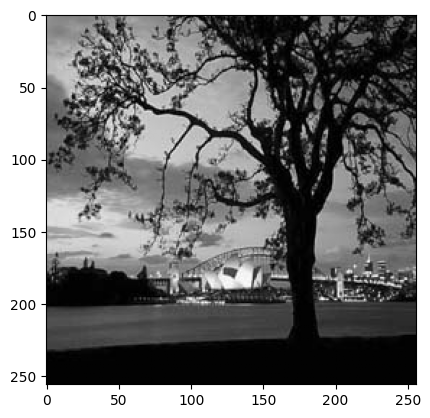

In [45]:
plt.imshow(image, cmap='gray')

In [46]:
def show_histogram(image, title):
    plt.figure(figsize=(10, 5))
    plt.title(f'Histogram {title}')
    plt.hist(image.ravel(), bins= 256, rwidth=0.8)
    plt.xlabel('Pixel Value')
    plt.ylabel('Count')
    plt.show()


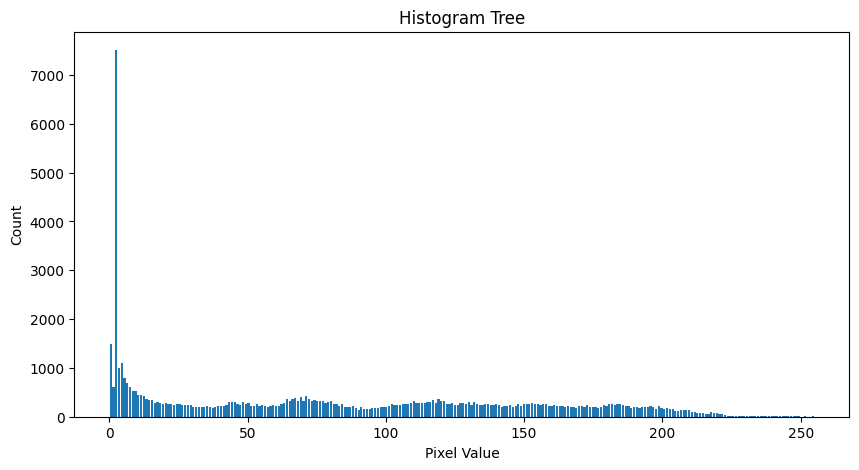

In [47]:
show_histogram(image, 'Tree')

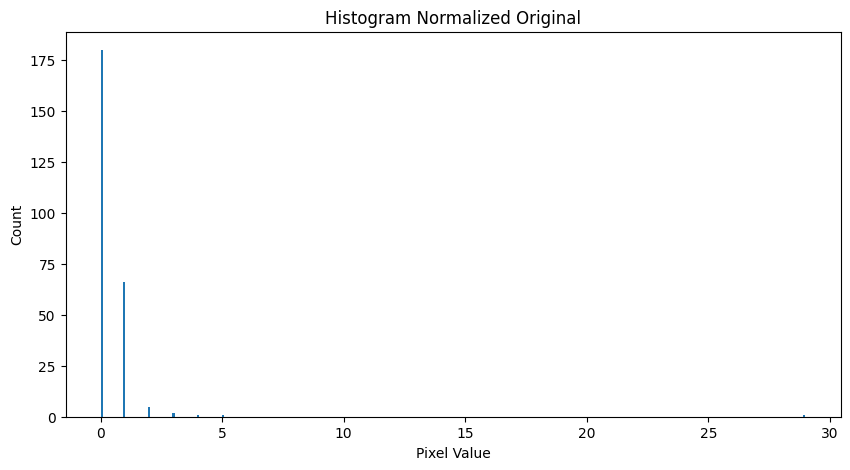

In [48]:
hist, bins = np.histogram(image.ravel(), bins=256, range=[0,256])
pdf = hist / (image.shape[0] * image.shape[1])  
show_histogram((pdf*255).astype(np.uint8), "Normalized Original")


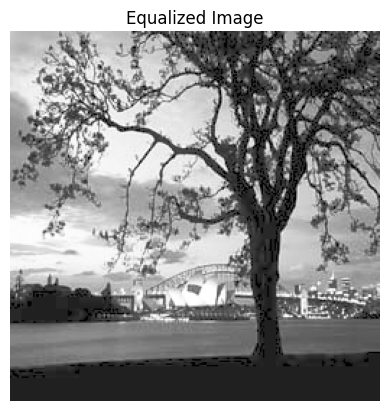

In [49]:
cdf = np.cumsum(pdf)
equalized_image = np.floor((255) * cdf[image]).astype(np.uint8)
plt.imshow(equalized_image, cmap='gray')
plt.title("Equalized Image")
plt.axis('off')
plt.show()

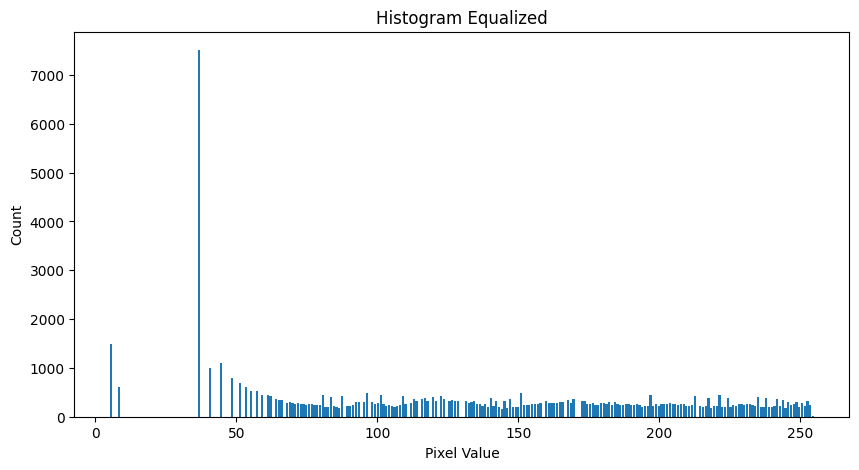

In [50]:
show_histogram(equalized_image, "Equalized")

In [51]:
def compute_stats(img, ref_img=None):
    img = img.astype(np.float64)
    hist, _ = np.histogram(img.flatten(), bins=256, range=[0,256])
    pdf = hist / np.sum(hist)
    pdf_nonzero = pdf[pdf > 0]
    entropy = -np.sum(pdf_nonzero * np.log2(pdf_nonzero))
    psnr = None
    if ref_img is not None:
        mse = np.mean((ref_img.astype(np.float64) - img)**2)
        psnr = 10 * np.log10((255**2) / mse)
    
    return np.mean(img), np.var(img), entropy, psnr


In [52]:
mean_orig, var_orig, entropy_orig, _ = compute_stats(image)
print(f"Original Image: Mean={mean_orig:.2f}, Variance={var_orig:.2f}, Entropy={entropy_orig:.2f}")

mean_eq, var_eq, entropy_eq, psnr_eq = compute_stats(equalized_image, image)
print(f"Equalized Image: Mean={mean_eq:.2f}, Variance={var_eq:.2f}, Entropy={entropy_eq:.2f}, PSNR={psnr_eq:.2f} dB")

Original Image: Mean=83.28, Variance=4577.72, Entropy=7.31
Equalized Image: Mean=129.27, Variance=5052.61, Entropy=7.12, PSNR=14.69 dB


# Part Two

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
image = cv2.imread('Q2/Couple.tiff', cv2.IMREAD_GRAYSCALE)

In [55]:
def show_histogram(image, title):
    plt.figure(figsize=(10,5))
    plt.title(f'Histogram {title}')
    plt.hist(image.ravel(), bins=256, rwidth=0.8)
    plt.xlabel('Pixel Value')
    plt.ylabel('Count')
    plt.show()

In [56]:
def compute_entropy(image):
    hist, _ = np.histogram(image.ravel(), bins=256, range=[0,256])
    pdf = hist / np.sum(hist)
    pdf_nonzero = pdf[pdf>0]
    return -np.sum(pdf_nonzero * np.log2(pdf_nonzero))

In [57]:
def compute_psnr(original, processed):
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(255**2 / mse)

In [58]:
def tiling_ahe(image, block_size):
    output = np.zeros_like(image)
    h, w = image.shape
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            hist, _ = np.histogram(block.ravel(), bins=256, range=[0,256])
            cdf = hist.cumsum()
            cdf = ((cdf - cdf.min()) / (cdf.max() - cdf.min()) * 255).astype(np.uint8)
            output[i:i+block_size, j:j+block_size] = cdf[block]
    return output

In [59]:
def sliding_ahe(image, window_size):
    pad = window_size // 2
    padded = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    output = np.zeros_like(image)
    h, w = image.shape
    for i in range(h):
        for j in range(w):
            window = padded[i:i+window_size, j:j+window_size]
            hist, _ = np.histogram(window.ravel(), bins=256, range=[0,256])
            cdf = hist.cumsum()
            cdf = ((cdf - cdf.min()) / (cdf.max() - cdf.min()) * 255).astype(np.uint8)
            output[i,j] = cdf[image[i,j]]
    return output

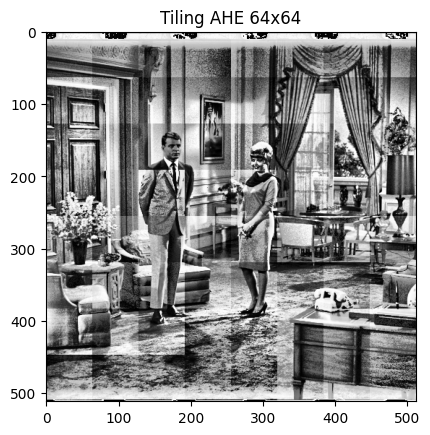

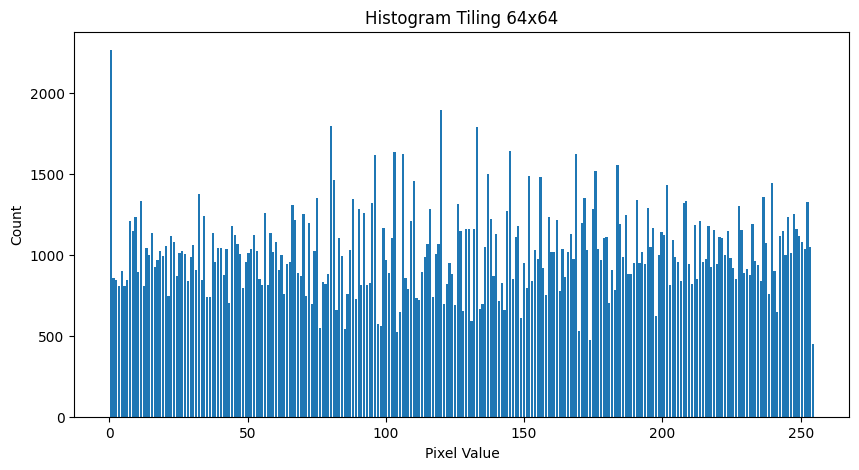

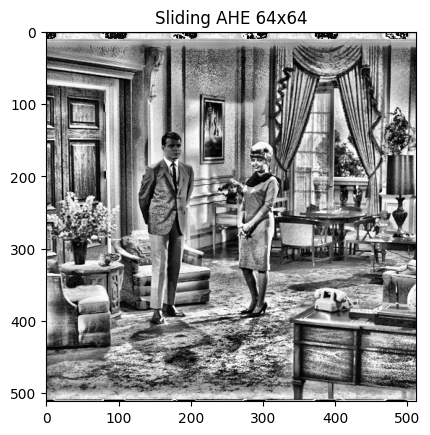

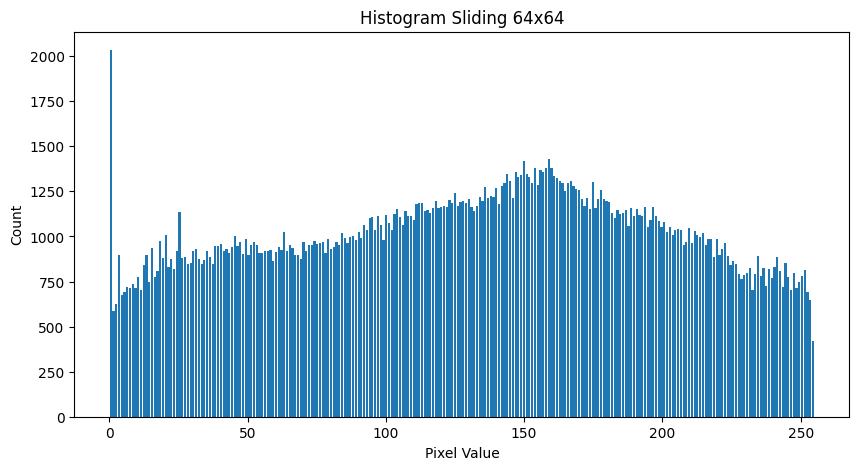

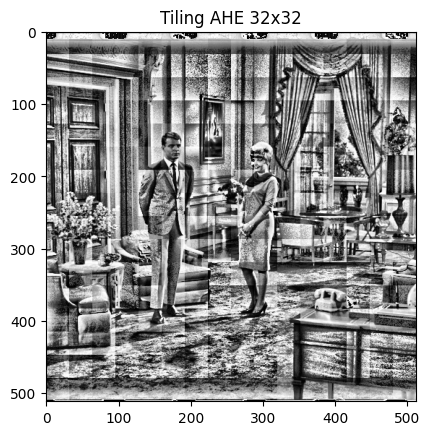

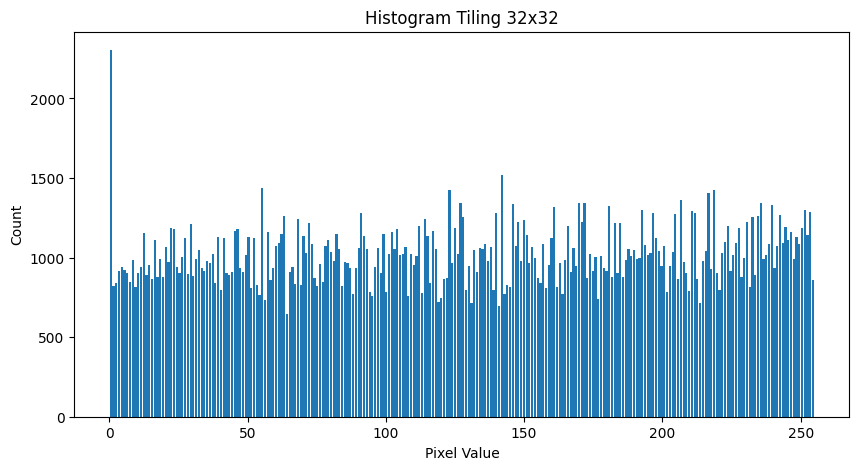

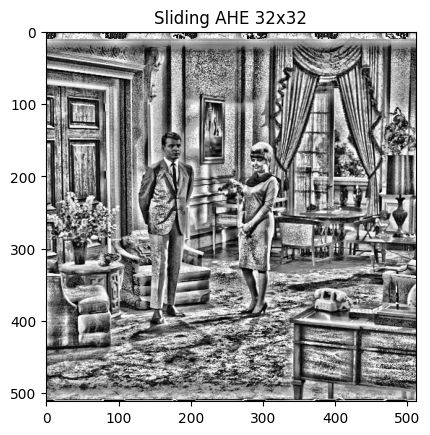

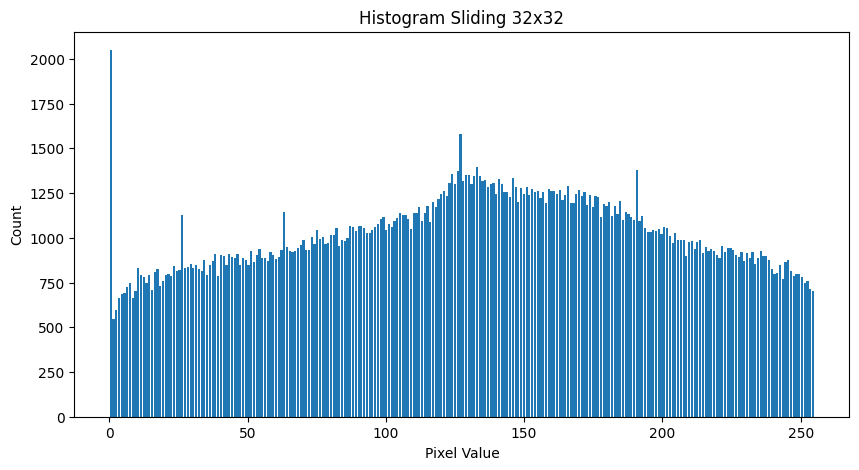

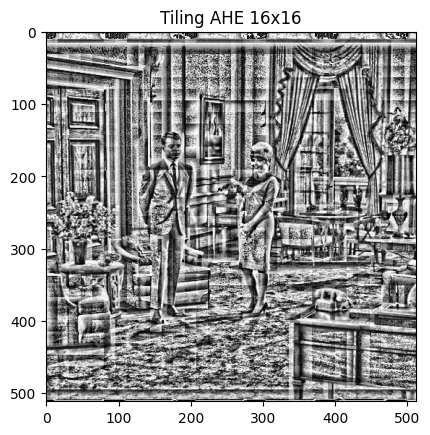

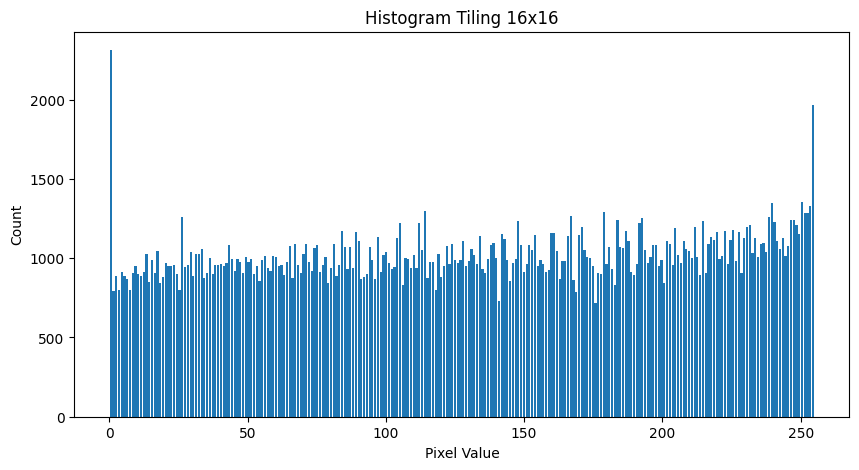

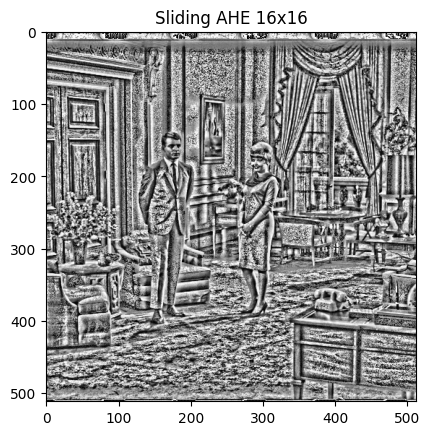

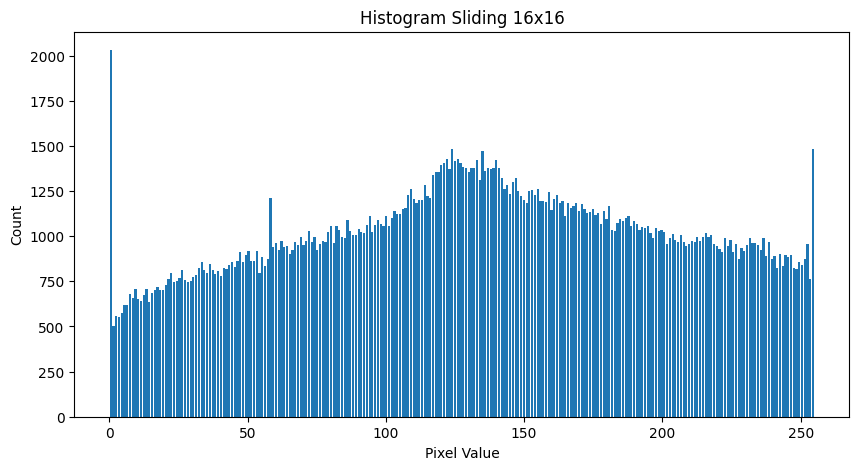

In [63]:
sizes = [64, 32, 16]
entropy_tiling = []
psnr_tiling = []
entropy_sliding = []
psnr_sliding = []

for size in sizes:
    out_tile = tiling_ahe(image, size)
    entropy_tiling.append(compute_entropy(out_tile))
    psnr_tiling.append(compute_psnr(image, out_tile))
    
    out_slide = sliding_ahe(image, size)
    entropy_sliding.append(compute_entropy(out_slide))
    psnr_sliding.append(compute_psnr(image, out_slide))
    
    plt.imshow(out_tile, cmap='gray')
    plt.title(f'Tiling AHE {size}x{size}')
    plt.show()
    show_histogram(out_tile, f'Tiling {size}x{size}')
    
    plt.imshow(out_slide, cmap='gray')
    plt.title(f'Sliding AHE {size}x{size}')
    plt.show()
    show_histogram(out_slide, f'Sliding {size}x{size}')

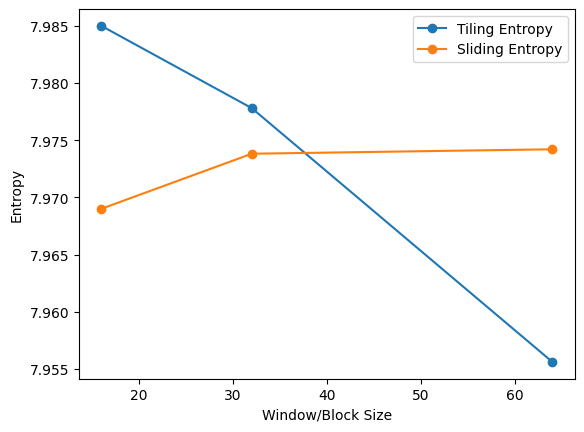

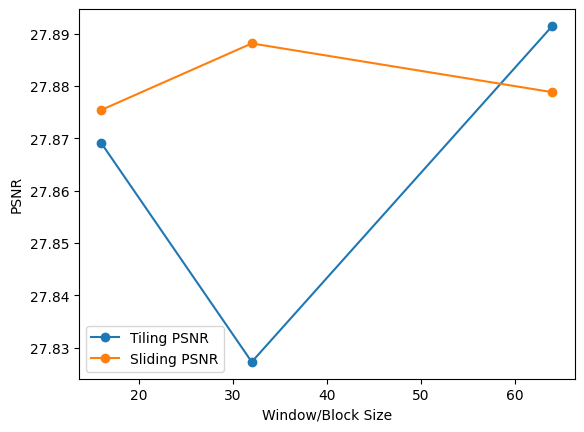

In [64]:
plt.figure()
plt.plot(sizes, entropy_tiling, '-o', label='Tiling Entropy')
plt.plot(sizes, entropy_sliding, '-o', label='Sliding Entropy')
plt.xlabel('Window/Block Size')
plt.ylabel('Entropy')
plt.legend()
plt.show()

plt.figure()
plt.plot(sizes, psnr_tiling, '-o', label='Tiling PSNR')
plt.plot(sizes, psnr_sliding, '-o', label='Sliding PSNR')
plt.xlabel('Window/Block Size')
plt.ylabel('PSNR')
plt.legend()
plt.show()
